## Tutorial  - Image processing

#TODO - Put the list of authors in here

#### Authors:
Romain JL Fétick, Alexis Lau

This notebook is designed to run in either Google Colab, or locally in your machine (need to install packages). 

#### Table of contents
This tutorial will cover the following topics: 
1. .. .. .. .. .. .. .. ..
2. .. .. .. .. .. .. ..
3. Image deconvolution

#### Introduction 
#TODO - write something to talk about image procesing. 

In [2]:
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import convolve, convolve1d, gaussian_filter
import math
from skimage import io
from scipy import fftpack
import sys

from scipy.signal import fftconvolve
from numpy.fft import fft2, fftshift, ifft2, ifftshift
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from scipy.ndimage import gaussian_filter


/var/folders/bz/1k8s98q90jn8l10thdwj_zdr0000gn/T/ipykernel_18826/4025149862.py:5: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve, convolve1d, gaussian_filter
/var/folders/bz/1k8s98q90jn8l10thdwj_zdr0000gn/T/ipykernel_18826/4025149862.py:5: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve, convolve1d, gaussian_filter
/var/folders/bz/1k8s98q90jn8l10thdwj_zdr0000gn/T/ipykernel_18826/4025149862.py:5: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve, convolve1d, gaussian_filter


#### TODO - write instruction to setup google drive directory

In [3]:
# !pip install git+https://github.com/ArcetriAdaptiveOptics/OAO24.git
# from oao24 import package_data

# dark_image = np.load(package_data.tuto3_folder() / "ID_110.npy")
# open_loop_image = np.load(package_data.tuto3_folder() / "ID_105.npy")

In [5]:
# seeing_limited_ima = open_loop_image-dark_image
# ima = np.clip(seeing_limited_ima, 0, np.inf)
# plt.imshow(ima)
# plt.colorbar()

## Deconvolution
1. Create an image with objects and PSFs provided
   1. Objects: Vesta, Ganymede (to be determined) 
   2. PSFs: Papyrus-liked PSFs 
2. Using Wiener Filtering to deconvolve an image 
   1. Equations for the noise estimation will be provided in the notebook 
3. MAP 
   1. Try to build your own MAP


Before starting to work on deconvolution, first of all we need to understand how is an image formed.

\begin{equation}
I = H*O+N, 
\end{equation}

where $I$ is the image, $H$ is the PSF, $O$ is the object and $N$ is the noise.


In [54]:
path = '/Users/alau/Desktop/deconvolution_tutorial/'
flux = 4e6
ron = 5

Here you will load the files to create the image. The PSF and the object are loaded into .fits format, which would require astropy to open it. 

In [55]:
fts = fits.open(path+'psf.fits')
psf = fts[0].data
fts.close()

fts = fits.open(path+'vesta.fits')
vesta = fts[0].data
fts.close()


Create an image with a given flux 

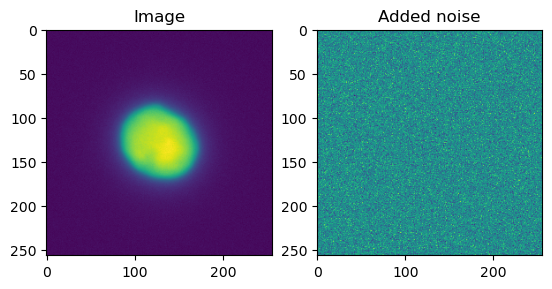

In [56]:
vesta = flux*vesta/np.sum(vesta)

nx = vesta.shape[0]

noise = ron*np.random.randn(nx,nx) # Gaussian noise
image = fftconvolve(vesta, psf, mode='same') + noise

fig, axes = plt.subplots(1,2)

axes[0].set_title('Image')
axes[0].imshow(image)

axes[1].set_title('Added noise')
axes[1].imshow(noise)


Now you have an image which includes the noise and PSF. It's time to start thinking about how to deblur the image. 

## Wiener filtering

$$
E\left\{ \hat{x}_{W,k} \right\} = E\left\{ \hat{w}_k \hat{y} \right\} = \frac{|\hat{h}_k|^2}{|\hat{h}_k|^2 + \frac{E\left\{ |\hat{n}_k|^2 \right\}}{E\left\{ |\hat{x}_k|^2 \right\}}} E\left\{ \hat{x}_k \right\}
$$

This equation represents the Wiener filtering process in a communication or signal processing context, where the goal is to estimate the original signal \(\hat{x}_{W,k}\) from a noisy observation \(\hat{y}\). Here's a breakdown of the components:

<!-- Equation Breakdown:

- $E\left\{ \cdot \right\}$ denotes the **expected value** operator, which is often used when working with random variables. This signifies that the equation provides an average or estimated value of the underlying variables.
  
- $\hat{x}_{W,k}$ is the **Wiener-filtered estimate** of the object at frequency index \(k\). The goal of the Wiener filter is to minimize the mean square error between the estimated signal and the true signal.

- $\hat{w}_k$ represents the **Wiener filter coefficient** at frequency index \(k\), which is a function of the signal and noise power spectra. This coefficient is applied to the noisy observation $\hat{y}$ to produce the filtered estimate.

- $\hat{y}$ is the **observed noisy signal** (typically in the frequency domain), which consists of both the original signal $\hat{x}_k$ and noise $\hat{n}_k$.

- $ \hat{h}_k $ represents the Fourier transform of the PSF (aka OTF) at index \(k\). 

- $ \hat{n}_k $ represents the **noise** in the system at frequency index \(k\), with $ E\left\{ |\hat{n}_k|^2 \right\} $ being its expected power.

- $ \hat{x}_k $ is the **original signal** at frequency index \(k\), and $ E\left\{ |\hat{x}_k|^2 \right\} $ represents its expected power. -->



Some helper functions for deconvolution

In [57]:
def circavg(tab):
    """
    Compute the circular average of a given array.
    """
    nx,ny = np.shape(tab)
    cx = (nx-1)/2
    cy = (ny-1)/2
    xx, yy = np.ogrid[0:nx, 0:ny]
    rr = np.sqrt((xx-cx)**2 + (yy-cy)**2)
    avg = np.zeros(int(rr.max()), dtype=tab.dtype)
    for i in range(int(rr.max())):
        index = np.where((rr >= i) * (rr < (i + 1)))
        avg[i] = tab[index[0], index[1]].sum() / index[0].size
    return avg

def estimate_noise(image_tf, otf):
    """
    Estimate the noise standard deviation for a given image.
    """
    msk_outside = otf < 1e-5
    ron_var = np.mean(np.abs(image_tf[msk_outside])**2) / nx**2
    return np.sqrt(ron_var)

def psd_model(nx, flux, pix_size):
    """
    Model of an object PSD as:
        PSF(f) = flux²/(1+(f/f_cut)^3)
    """
    xx,yy = np.mgrid[0:nx,0:nx] - nx//2
    rr = np.sqrt(xx**2+yy**2)
    rho = nx/pix_size/2
    return flux**2/(1+(rr/rho)**3)

def likelihood(image, obj_tf, otf, weights):
    """
    Compute the likelihood such as:
        L=||weights*(img-obj⨂psf)||²
    where `weights` is the inverse of the noise variance.
    """
    conv = np.real(ifftshift(ifft2(obj_tf*otf)))
    fun = np.sum(weights*(image-conv)**2.0) / 2.0
    dd   = -fft2(weights*(image-conv))
    grad = dd * np.conjugate(otf) #aux coins
    grad = np.real(ifftshift(ifft2(grad))) #retour domaine réel
    return fun, grad

def regularization_quadratic(obj):
    """
    Compute a regularization term of the form:
        R=||𝛁x||²+||𝛁y||²
    """
    dx = obj - np.roll(obj,1,axis=0)
    dy = obj - np.roll(obj,1,axis=1)
    fun = np.sum(dx**2+dy**2)
    grad = dx - np.roll(dx,-1,axis=0) + dy - np.roll(dy,-1,axis=1)
    return fun, grad

From the equation above, try to build wiener filtering function: 

Hint: you need to estimate the noise of the image, and a PSD model as a prior for the wiener filtering

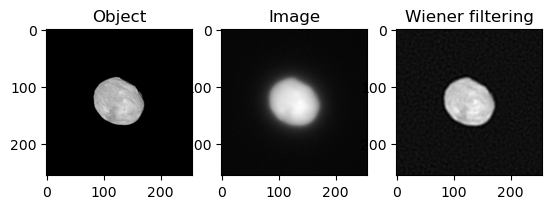

In [58]:
# WIENER FILTER (analytical solution)
ft_noise = fftshift(fft2(fftshift(noise)))
ft_vesta = fftshift(fft2(fftshift(vesta)))

psd_noise = nx**2 * estimate_noise(ft_image, otf)**2
psd_obj = psd_model(nx, np.sum(image), 120)

def wiener_filter (image, psf, psd_noise, psd_obj):
    ft_image = fftshift(fft2(fftshift(image)))
    otf = fftshift(fft2(fftshift(psf)))
    wiener_filter = np.conjugate(otf)/(np.abs(otf)**2 + psd_noise/psd_obj)
    ft_deconv_wiener = wiener_filter*ft_image

    return np.real(ifftshift(ifft2(ifftshift(ft_deconv_wiener))))

deconv_wiener = wiener_filter(image, psf, psd_noise, psd_obj)

fig, ax = plt.subplots(1,3)
ax[0].set_title('Object')
ax[0].imshow(vesta, cmap='gray')


ax[1].set_title('Image')
ax[1].imshow(image, cmap='gray')

ax[2].set_title('Wiener filtering')
ax[2].imshow(deconv_wiener, cmap='gray')

# add colour bar in here


## Maximum A Posteriori 




#TODO add more descirption and equations

In [ ]:
# MAXIMUM A POSTERIORI (with minimisation algorithm)
class MAPcriterion:
    def __init__(self, image, psf, weights):
        self.iteration = 0
        self.criterion = 0
        self.image = image
        self.otf = fft2(psf)
        self.weights = weights
        image_less_noisy = gaussian_filter(image, 1)
        self.norma = regularization_quadratic(image_less_noisy)[0]/image.size
        self.norma *= 100 # tune hyper-parameter (empirical)
        
    def __call__(self, obj_flat):
        obj = np.reshape(obj_flat, self.otf.shape)
        obj_tf = fft2(obj)
        likeli,likeli_g = likelihood(self.image, obj_tf, self.otf, self.weights)
        regul,regul_g = regularization_quadratic(obj)
        map_fun = likeli + regul/self.norma
        map_grad = likeli_g + regul_g/self.norma
        self.criterion = map_fun
        return map_fun, map_grad.flatten()
    
    def callback(self, obj_flat):
        self.iteration += 1
        print('[%2u] %5.8g'%(self.iteration,self.criterion))

In [35]:
weights = 1/estimate_noise(ft_image, otf)**2
map_criterion = MAPcriterion(image, psf, weights)

obj_guess = (image*(image>0)).flatten()
bounds = ((0,None),)*len(obj_guess) # projection on the positive subspace
solution = fmin_l_bfgs_b(map_criterion, obj_guess, callback=map_criterion.callback, bounds=bounds, factr=10, pgtol=1e-8)
print(solution[2]['task'])
deconv_map = solution[0].reshape(*psf.shape)

[ 1] 1416844.3
[ 2] 129473.03
[ 3] 89052.214
[ 4] 52500.253
[ 5] 43978.47
[ 6] 41500.141
[ 7] 39573.256
[ 8] 39145.221
[ 9] 38841.154
[10] 38544.288
[11] 38455.103
[12] 38429.585
[13] 38421.374
[14] 38413.937
[15] 38411.087
[16] 38409.171
[17] 38409.16
[18] 38408.987
[19] 38408.809
[20] 38403.619
[21] 38403.113
[22] 38402.947
[23] 38402.942
[24] 38402.875
[25] 38402.464
[26] 38402.464
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


In [46]:
# Get the variables for plotting and comparing the results
otf = fftshift(fft2(fftshift(psf)))

ft_image = fftshift(fft2(fftshift(image)))
ft_vesta = fftshift(fft2(fftshift(vesta)))
ft_noise = fftshift(fft2(fftshift(noise)))

psd_noise = nx**2 * estimate_noise(ft_image, otf)**2
psd_obj = psd_model(nx, np.sum(image), 120)

wiener_filter = np.conjugate(otf)/(np.abs(otf)**2 + psd_noise/psd_obj)
ft_deconv_wiener = wiener_filter*ft_image
deconv_wiener = np.real(ifftshift(ifft2(ifftshift(ft_deconv_wiener))))



(0.0, 255.0)

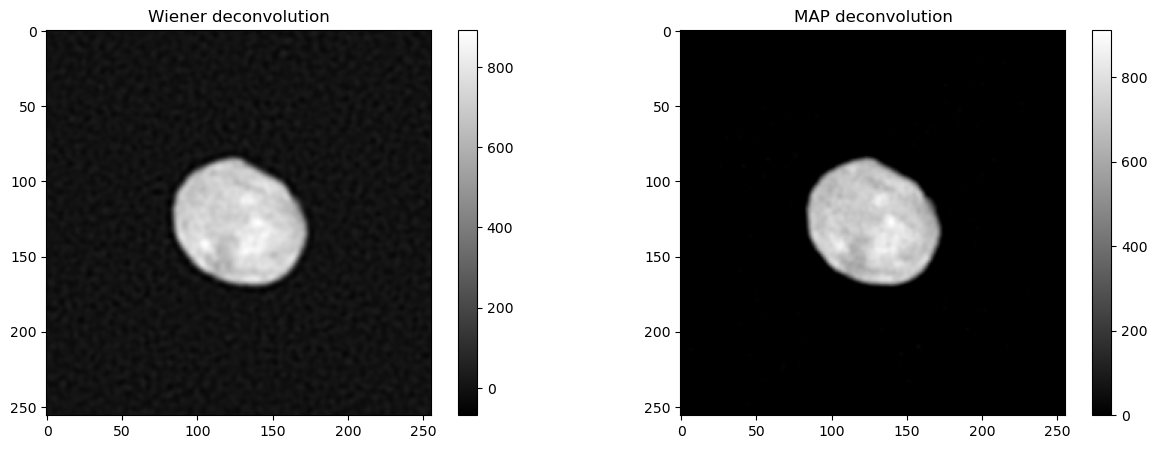

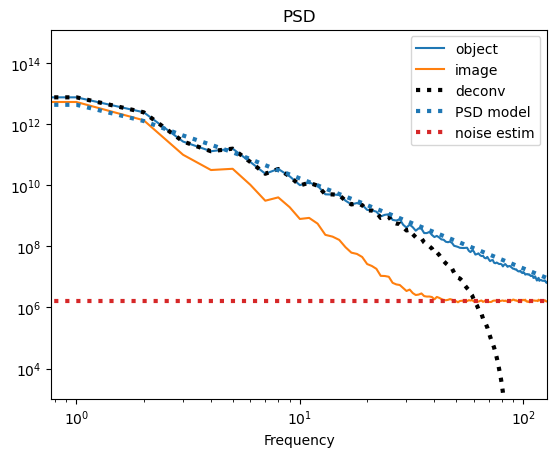

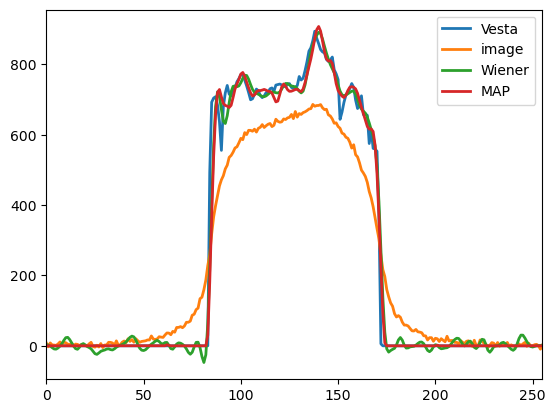

In [47]:
#%% PLOT RESULTS
plt.figure(2, figsize=(15,5))
plt.clf()
plt.subplot(121)
plt.title('Wiener deconvolution')
plt.imshow(deconv_wiener, cmap='gray')
plt.colorbar()
plt.subplot(122)
plt.title('MAP deconvolution')
plt.imshow(deconv_map, cmap='gray')
plt.colorbar()

plt.figure(3)
plt.clf()
plt.title('PSD')

plt.loglog(circavg(np.abs(ft_vesta)**2), label='object')
plt.loglog(circavg(np.abs(ft_image)**2), label='image')
plt.loglog(circavg(np.abs(ft_deconv_wiener)**2), lw=3, ls=':', c='k', label='deconv')

plt.loglog(circavg(psd_obj), c='C0', lw=3, ls=':', label='PSD model')
plt.loglog(circavg(psd_noise*np.ones((nx,nx))), c='C3', lw=3, ls=':', label='noise estim')

plt.xlabel('Frequency')
plt.legend()
plt.ylim(bottom=1e3)
plt.xlim(right=nx//2)

plt.figure(4)
plt.clf()
plt.plot(np.mean(vesta[nx//2-1:nx//2+2,:], axis=0), lw=2, label='Vesta')
plt.plot(image[nx//2,:], lw=2, label='image')
plt.plot(deconv_wiener[nx//2,:], lw=2, label='Wiener')
plt.plot(deconv_map[nx//2,:], lw=2, label='MAP')
plt.legend()
plt.xlim(0,nx-1)

Tasks: 
1. Impact of S/N on deconvolution:
   - How does S/N change the deconvolution result?
2. Impact of PSFs accuracy on deconvolution 
   - How does the accuracy of PSF changes the deconvolution result? 